In [289]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as grad
import matplotlib.pyplot as plt

import numpy as np

In [343]:
from IPython.display import clear_output
plot = True

# First ODE

In [446]:
n = nn.Sequential(nn.Linear(1, 4), nn.ReLU(),
                  nn.Linear(4, 4), nn.ReLU(),
                  nn.Linear(4, 1))
opt = optim.Adam(n.parameters(), lr=0.001)

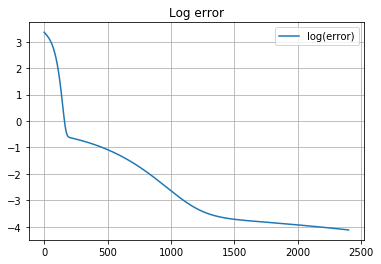

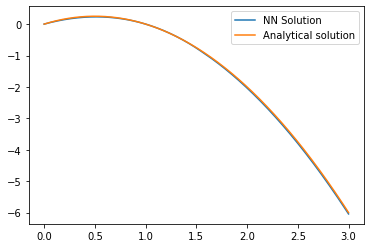

KeyboardInterrupt: 

In [447]:
errors = []
for i in range(12001):

    loss = 0
    elems = 50
    X = torch.linspace(0, 3, elems)
    dx = X[1] - X[0]
    X = X[None, :]

    x_prev, x_cur, x_next = X.T[0:-2], X.T[1:-1], X.T[2:]

    opt.zero_grad()

    y_prev = n(x_prev)
    y_cur  = n(x_cur)
    y_next = n(x_next)

    dy_prev = (y_cur - y_prev) / (dx)
    dy_cur  = (y_next - y_prev) / (2 * dx)
    dy_next = (y_next - y_cur) / (dx)

    dy2 = (1 / (2 * dx)) * (dy_next - dy_prev)

    dpsi = (1 - 2 * x_cur) * y_cur + (x_cur - x_cur ** 2) * dy_cur
    d2psi = -2 * y_cur + (1 - 2 * x_cur) * dy_cur + (x_cur - x_cur ** 2) * dy2

    loss = (d2psi + dpsi + 1 + 2 * x_cur) ** 2
    loss = torch.mean(loss)
    loss.backward()
    opt.step()
    errors.append(loss.item())

    if plot and i % 600 == 0:

        clear_output()

        plt.title("Log error")
        plt.plot(np.log(errors), label='log(error)')
        plt.grid()
        plt.legend()
        plt.show()


        loss = 0
        elems = 500
        X = torch.linspace(0, 3, elems)
        dx = X[1] - X[0]
        X = X[None, :]
        y = []
        for x in X.T:
          y += [n(x)]

        z = X[0].detach().numpy()

        plt.plot(z, z * (1 - z) * y, label='NN Solution')
        plt.plot(z, z * (1 - z), label='Analytical solution')
        plt.legend()

        plt.show()

# PDE

In [495]:
n = nn.Sequential(nn.Linear(2, 15), nn.ReLU(),
                  nn.Linear(15, 15), nn.ReLU(),
                  nn.Linear(15, 15), nn.ReLU(),
                  nn.Linear(15, 1))
opt = optim.Adam(n.parameters(), lr=0.00001)

In [492]:
dx, dt = 0.01, 0.01

x = torch.arange(0, 1, dx)
t = torch.arange(0, 1, dt)

X, T = torch.meshgrid((x, t))

grid = torch.stack((X[1:-1].reshape(-1, 1), T[:, 1:-1].reshape(-1, 1)), dim=1)[:, :, 0]
grid = grid[:, :, None]
grid = grid.transpose(2, 1)

cells = grid.shape[0]

In [493]:
DX_l = torch.tensor([[-dx, 0]])
DX_r = torch.tensor([[dx, 0]])
DT_l = torch.tensor([[0, -dt]])
DT_r = torch.tensor([[0, dt]])

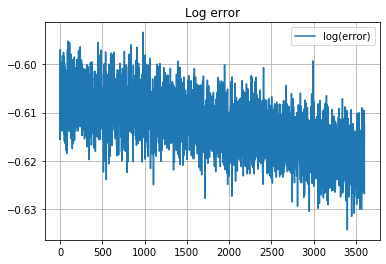

KeyboardInterrupt: 

In [494]:
errors = []
for i in range(12001):

    loss = 0
  
    batch_set = np.random.randint(0, cells, size=int(cells * 1))
    batch_grd = grid[batch_set]
    
    x_prev, x_cur, x_next = batch_grd + DX_l, batch_grd, batch_grd + DX_r
    t_prev, t_cur, t_next = batch_grd + DT_l, batch_grd, batch_grd + DT_r
    
    opt.zero_grad()
  
    y_prev_x = n(x_prev)
    y_cur_x  = n(x_cur)
    y_next_x = n(x_next)
    
    y_prev_t = n(t_prev)
    y_cur_t  = n(t_cur)
    y_next_t = n(t_next)
    
    dx_next = (y_next_x - y_cur_x) / (dx)
    dx_cur  = (y_next_x - y_prev_x) / (2 * dx)
    dx_prev  = (y_cur_x - y_prev_x) / (dx)
    
    dt_next = (y_next_t - y_cur_t) / (dt)
    dt_cur  = (y_next_t - y_prev_t) / (2 * dt)
    dt_prev  = (y_cur_t - y_prev_t) / (dt)
    
    d2x = (dx_next - dx_prev) / (2 * dx)
    d2t = (dt_next - dt_prev) / (2 * dt)
    
    dpsi_t = (-1 + x_cur) * x_cur * ((-1 + 2 * t_cur) * y_cur_x + (-1 + t_cur) * t_cur * dt_cur)
    dpsi_x = (-1 + t_cur) * t_cur * ((-1 + 2 * x_cur) * y_cur_x + (-1 + x_cur) * x_cur * dx_cur)
    
    loss = (dpsi_t + dpsi_x - (-2 * t_cur + 2 * t_cur ** 2 - 2 * x_cur + 2 * x_cur ** 2)) ** 2
    
    loss = torch.mean(loss)
    loss.backward()
    opt.step()
    errors.append(loss.item())

    if plot and i % 600 == 0:

        clear_output()

        plt.title("Log error")
        plt.plot(np.log(errors), label='log(error)')
        plt.grid()
        plt.legend()
        plt.show()

In [486]:
errors

[0.6726618409156799,
 0.6675055027008057,
 0.6407564878463745,
 0.6516256332397461,
 0.6442753076553345,
 0.6404458284378052,
 0.667015552520752,
 0.6548585891723633,
 0.6390490531921387,
 0.6272305250167847,
 0.6615750193595886,
 0.6766411066055298,
 0.6673191785812378,
 0.65349280834198,
 0.6440076231956482,
 0.6555417776107788,
 0.6793160438537598,
 0.640609622001648,
 0.6442769765853882,
 0.6846758723258972,
 0.6263631582260132,
 0.6506639122962952,
 0.6639024019241333,
 0.6240107417106628,
 0.6775827407836914,
 0.6217541694641113,
 0.6522459983825684,
 0.68134605884552,
 0.6902871131896973,
 0.663163959980011,
 0.6244742274284363,
 0.6211057901382446,
 0.6118006706237793,
 0.6022701263427734,
 0.6620998978614807,
 0.6502645611763,
 0.6483533978462219,
 0.6608399748802185,
 0.6608366966247559,
 0.6498416066169739,
 0.5925019383430481,
 0.6712312698364258,
 0.6324618458747864,
 0.6744887232780457,
 0.6251245737075806,
 0.6799107193946838,
 0.6529121398925781,
 0.6737787127494812,
 0

In [434]:
grid.shape

torch.Size([360, 1, 2])

In [436]:
y = n(grid)
x = grid[:, 0, 0]
t = grid[:, 0, 1]

In [437]:
X.shape

torch.Size([20, 20])

In [438]:
y.shape

torch.Size([360, 1, 1])

In [439]:
y

tensor([[[ 5.4587]],

        [[ 5.1421]],

        [[ 4.8255]],

        [[ 4.5088]],

        [[ 4.1922]],

        [[ 3.8756]],

        [[ 3.5590]],

        [[ 3.2424]],

        [[ 2.9258]],

        [[ 2.6092]],

        [[ 2.2926]],

        [[ 1.9760]],

        [[ 1.6594]],

        [[ 1.3428]],

        [[ 1.0261]],

        [[ 0.7095]],

        [[ 0.3929]],

        [[ 0.0763]],

        [[ 5.4587]],

        [[ 5.1421]],

        [[ 4.5185]],

        [[ 4.2019]],

        [[ 3.8853]],

        [[ 3.5687]],

        [[ 3.2521]],

        [[ 2.9355]],

        [[ 2.6189]],

        [[ 2.3023]],

        [[ 1.9856]],

        [[ 1.6690]],

        [[ 1.3524]],

        [[ 1.0358]],

        [[ 0.7192]],

        [[ 0.4026]],

        [[ 0.0860]],

        [[-0.2306]],

        [[ 5.1517]],

        [[ 4.8351]],

        [[ 4.5185]],

        [[ 4.2019]],

        [[ 3.5784]],

        [[ 3.2618]],

        [[ 2.9451]],

        [[ 2.6285]],

        [[ 2.3119]],

        [[